In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import cm
import matplotlib.image as mpimg
%matplotlib inline
import scipy.optimize
import numpy as np

In [2]:
def read_data(path):
    """There are several csv files in path that get combined."""
    import os
    dfs = []
    for file in os.listdir(path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(path, file), sep=';')
            df['File'] = file
            dfs.append(df)
    return pd.concat(dfs)

raw_data = read_data('data/SR-EELS_Charakterisierung_Train-Test_-33%_RAW')
corrected_data = read_data('data/SR-EELS_Charakterisierung_Train-Test_-33%_corrected')
# Die korrigierten Bilder sind 364 Pixel höher, weshalb 'x-position' korrigiert werden muss.
# Der ungefähre Wert wird am ende desNotebooks ermittelt.
corrected_data['x-position'] -= 117
assert len(raw_data) == len(corrected_data)

colors = plt.get_cmap('Vega10')

In [3]:
raw_data.head()

,y-position,y-error,x-position,x-error,left-position,left-error,right-position,right-error,width,width-error,threshold,fitted-x-position,fitted-left-position,fitted-right-position,File
0,80.035454,0.0,2596.670166,0.0,2296.0,0.0,2897.0,0.0,601.0,0.0,0.0,2596.399373,2295.699615,2897.112936,Cal_2.csv
1,111.996529,0.0,2596.124512,0.0,2296.0,0.0,2897.0,0.0,601.0,0.0,0.0,2596.445332,2296.258627,2896.796915,Cal_2.csv
2,143.988495,0.0,2596.274658,0.0,2297.0,0.0,2896.0,0.0,599.0,0.0,0.0,2596.491668,2296.811295,2896.482874,Cal_2.csv
3,176.013565,0.0,2596.472900,0.0,2297.0,0.0,2896.0,0.0,599.0,0.0,0.0,2596.538587,2297.357880,2896.171039,Cal_2.csv
4,208.001602,0.0,2596.507324,0.0,2298.0,0.0,2896.0,0.0,598.0,0.0,0.0,2596.586184,2297.897426,2895.862331,Cal_2.csv


In [4]:
int(len(raw_data) / 7)

124

Mittlere Steigung der korrigierten Kurven: 0.000219 (stdv: 0.000534)
Minimale und maximale Steigung: -0.000522, 0.001312
Mittlerer Wert von p2 der korrigierten Kurven: -2.609522e-07 (stdv: 3.474630e-07)
Mittlerer Wert von p3 der korrigierten Kurven: 2.537753e-11 (stdv: 5.957454e-11)


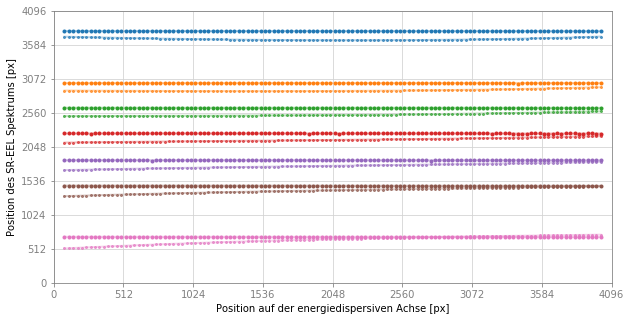

In [5]:
def get_y_vs_x(df):
    pairs = []
    for pos in sorted(df.File.unique()):
        selected = df.loc[df.File == pos]
        #pairs.append({'x': selected['y-position'], 'y': selected['left-position']})
        #pairs.append({'x': selected['y-position'], 'y': selected['x-position']})
        pairs.append({'x': selected['y-position'], 'y': selected['right-position']})
        #print(pos)
    poly = lambda x, p1, p2, p3, p4: p1 + p2 * x + p3 * x**2 + p4 * x**3
    for pair in pairs:
        # There is an warining when using the default method ('lm').
        popt, pcov = scipy.optimize.curve_fit(poly, pair['x'], pair['y'], p0=(pair['y'][0], 0, 0, 0))
        fit = [poly(x, *popt) for x in pair['x']]
        pair['fit'] = fit
        pair['slope'] = popt[1]
        pair['2nd'] = popt[2]
        pair['3rd'] = popt[3]
    return pairs

def make_pos_plot():
    raw_curves = get_y_vs_x(raw_data)
    corrected_curves = get_y_vs_x(corrected_data)

    slopes = [curve['slope'] for curve in corrected_curves]
    print('Mittlere Steigung der korrigierten Kurven: {:f} (stdv: {:f})'.format(np.mean(slopes), np.std(slopes)))
    print('Minimale und maximale Steigung: {:f}, {:f}'.format(np.min(slopes), np.max(slopes)))
    second = [curve['2nd'] for curve in corrected_curves]
    print('Mittlerer Wert von p2 der korrigierten Kurven: {:e} (stdv: {:e})'.format(np.mean(second), np.std(second)))
    third = [curve['3rd'] for curve in corrected_curves]
    print('Mittlerer Wert von p3 der korrigierten Kurven: {:e} (stdv: {:e})'.format(np.mean(third), np.std(third)))

    plt.figure(figsize=(10, 5))
    plt.xlim(0, 4096)
    plt.xticks(range(0, 4097, 512))
    plt.ylim(0, 4096)
    plt.yticks(range(0, 4097, 512))
    plt.xlabel('Position auf der energiedispersiven Achse [px]')
    plt.ylabel('Position des SR-EEL Spektrums [px]')
    for raw, corrected, index in zip(raw_curves, corrected_curves, range(len(raw_curves))):
        color = colors(index)
        plt.plot(raw['x'], raw['y'], '.', ms=4, c=color, alpha=0.66)
        plt.plot(raw['x'], raw['fit'], c=color, linewidth=2, zorder=-1, alpha=0.33)
        plt.plot(corrected['x'], corrected['y'], '.', ms=6, c=color)
        plt.plot(corrected['x'], corrected['fit'], c=color, linewidth=2, zorder=-1, alpha=0.33)
    plt.savefig('Bilder/SR-EELS_Train-Test_opt_Pos-vs-E')
    plt.show()

make_pos_plot()

Mittlere Steigung der korrigierten Kurven: -0.000263 (stdv: 0.000689)
Minimale und maximale Steigung: -0.001351, 0.000826
Mittlerer Wert von p2 der korrigierten Kurven: -1.520382e-07 (stdv: 1.568547e-07)


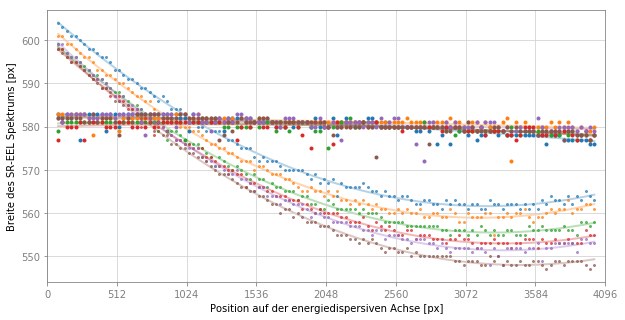

In [6]:
def get_width_vs_x(df):
    pairs = []
    for pos in sorted(df.File.unique()):
        if pos == 'Cal_7.csv':
            break
        selected = df.loc[df.File == pos]
        pairs.append({'x': selected['y-position'], 'width': selected['width']})
        #print(pos)
    poly = lambda x, p1, p2, p3: p1 + p2 * x + p3 * x**2
    for pair in pairs:
        # There is an warining when using the default method ('lm').
        popt, pcov = scipy.optimize.curve_fit(poly,
                                              pair['x'],
                                              pair['width'],
                                              p0=(pair['width'][0], 0, 0)
                                             )
        fit = [poly(x, *popt) for x in pair['x']]
        pair['fit'] = fit
        pair['slope'] = popt[1]
        pair['2nd'] = popt[2]
    return pairs

def make_width_plot():
    raw_curves = get_width_vs_x(raw_data)
    corrected_curves = get_width_vs_x(corrected_data)

    slopes = [curve['slope'] for curve in corrected_curves]
    print('Mittlere Steigung der korrigierten Kurven: {:f} (stdv: {:f})'.format(np.mean(slopes), np.std(slopes)))
    print('Minimale und maximale Steigung: {:f}, {:f}'.format(np.min(slopes), np.max(slopes)))
    second = [curve['2nd'] for curve in corrected_curves]
    print('Mittlerer Wert von p2 der korrigierten Kurven: {:e} (stdv: {:e})'.format(np.mean(second), np.std(second)))

    plt.figure(figsize=(10, 5))
    plt.xlim(0, 4096)
    plt.xticks(range(0, 4097, 512))
    #plt.ylim(0, 640)
    #plt.yticks(range(0, 4097, 128))
    plt.xlabel('Position auf der energiedispersiven Achse [px]')
    plt.ylabel('Breite des SR-EEL Spektrums [px]')
    for raw, corrected, index in zip(raw_curves, corrected_curves, range(len(raw_curves))):
        color = colors(index)
        plt.plot(raw['x'], raw['width'], '.', ms=4, c=color, alpha=0.66)
        plt.plot(raw['x'], raw['fit'], c=color, linewidth=2, zorder=-1, alpha=0.33)
        plt.plot(corrected['x'], corrected['width'], '.', ms=6, c=color)
        plt.plot(corrected['x'], corrected['fit'], c=color, linewidth=2, zorder=-1, alpha=0.33)
    plt.savefig('Bilder/SR-EELS_Train-Test_opt_Width-vs-E')
    plt.show()

make_width_plot()

Parameter des optimalen Fit: 580.679863, -0.000285, 6.749430e-08
p2 / p3 = 4226


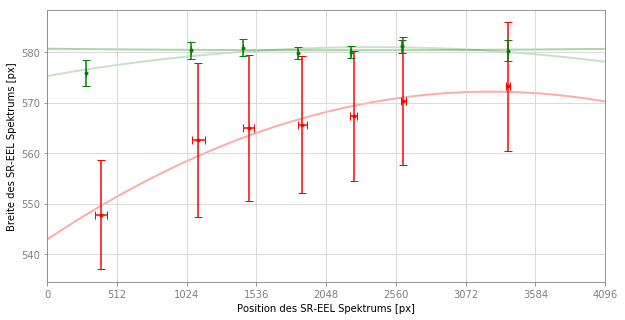

In [7]:
def df2dict(df):
    def filter_df(df):
        """The spectrum of Cal_7 touches the image border for values < 900"""
        return df[(df['File'] != 'Cal_7.csv') | (df['y-position'] > 900)]
    df_mean = filter_df(df).groupby('File').mean()
    df_stdv = filter_df(df).groupby('File').std()
    return {
        'y': df_mean['x-position'],
        'y_err': df_stdv['x-position'],
        'width': df_mean['width'],
        'width_err': df_stdv['width']
    }

def make_width2_plot():
    raw_curve = df2dict(raw_data)
    corrected_curve = df2dict(corrected_data)

    plt.figure(figsize=(10, 5))
    plt.xlim(0, 4096)
    plt.xticks(range(0, 4097, 512))
    #plt.ylim(0, 640)
    #plt.yticks(range(0, 4097, 128))
    plt.xlabel('Position des SR-EEL Spektrums [px]')
    plt.ylabel('Breite des SR-EEL Spektrums [px]')
    plt.errorbar(raw_curve['y'],
                 raw_curve['width'],
                 xerr=raw_curve['y_err'],
                 yerr=raw_curve['width_err'],
                 fmt='.',
                 capsize=4,
                 capthick=1,
                 c='r'
                )
    
    poly = lambda x, p1, p2, p3: p1 + p2 * x + p3 * x**2
    line = lambda x, b, m: b + m * x
    popt, pcov = scipy.optimize.curve_fit(poly,
                                          raw_curve['y'],
                                          raw_curve['width'],
                                          p0=(raw_curve['width'][0], 0, 0)
                                         )
    x_fit = np.linspace(0, 4096, 100)
    y_fit = [poly(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c='r', linewidth=2, zorder=-1, alpha=0.33)
    
    plt.errorbar(corrected_curve['y'],
                 corrected_curve['width'],
                 xerr=corrected_curve['y_err'],
                 yerr=corrected_curve['width_err'],
                 fmt='.',
                 capsize=4,
                 capthick=1,
                 c='g'
                )
    
    popt, pcov = scipy.optimize.curve_fit(poly,
                                          corrected_curve['y'],
                                          corrected_curve['width'],
                                          p0=(raw_curve['width'][0], 0, 0)
                                         )
    x_fit = np.linspace(0, 4096, 100)
    y_fit = [poly(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c='g', linewidth=2, zorder=-1, alpha=0.22)
    
    popt, pcov = scipy.optimize.curve_fit(poly,
                                          corrected_curve['y'][:-1],
                                          corrected_curve['width'][:-1],
                                          p0=(raw_curve['width'][0], 0, 0)
                                         )
    x_fit = np.linspace(0, 4096, 100)
    y_fit = [poly(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c='g', linewidth=2, zorder=-1, alpha=0.33)
    print('Parameter des optimalen Fit: {:f}, {:f}, {:e}'.format(*popt))
    print('p2 / p3 = {:d}'.format(abs(int(popt[1] / popt[2]))))
    
    plt.savefig('Bilder/SR-EELS_Train-Test_opt_Width-vs-Pos')
    plt.show()

make_width2_plot()

In [8]:
print('Diese Werte nutze ich um die Verschiebung, auf Grund der unterschiedlichen Bildhöhe, zu bestimmen:')
print(df2dict(raw_data)['y'])
print(df2dict(corrected_data)['y'])
# Cal_1.csv liegt etwa beim Maximum der Breite. Dort sollte deshalb keine Verschiebung vorhanden sein.
# Da das Maximum nicht im Zentrum liegt, 
# wird das Bild durch die Korrektur an beiden Seiten unterschiedlich stark erweitert.

Diese Werte nutze ich um die Verschiebung, auf Grund der unterschiedlichen Bildhöhe, zu bestimmen:
File
Cal_1.csv    3385.465938
Cal_2.csv    2615.205824
Cal_3.csv    2250.176118
Cal_4.csv    1872.495058
Cal_5.csv    1479.188471
Cal_6.csv    1108.222848
Cal_7.csv     395.764921
Name: x-position, dtype: float64
File
Cal_1.csv    3385.057538
Cal_2.csv    2602.244237
Cal_3.csv    2229.555333
Cal_4.csv    1842.706298
Cal_5.csv    1438.450719
Cal_6.csv    1055.764907
Cal_7.csv     287.840706
Name: x-position, dtype: float64


In [9]:
corrected_data.columns

Index(['y-position', 'y-error', 'x-position', 'x-error', 'left-position',
       'left-error', 'right-position', 'right-error', 'width', 'width-error',
       'threshold', 'fitted-x-position', 'fitted-left-position',
       'fitted-right-position', 'File'],
      dtype='object')